In [41]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import numpy as np
from tqdm import tqdm
import cv2

data_path='M:/dataset/dog_cat/'


# 加载数据集

猫狗大战：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [42]:

np.random.seed(2017)

n = 25000
X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range( int(n/2) )):
    X[i] = cv2.resize(cv2.imread(data_path+'train/cat.%d.jpg' % i), (224, 224))
    X[i+int(n/2)] = cv2.resize(cv2.imread(data_path+'train/dog.%d.jpg' % i), (224, 224))

y[int(n/2):] = 1

 13%|█████████▋                                                                  | 1603/12500 [00:08<00:57, 188.87it/s]


KeyboardInterrupt: 

# 分为训练集和验证集

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py


In [4]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

In [5]:
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(base_model.output.shape)

#model_checkpoint = ModelCheckpoint('./dog_cat_tmp.hdf5', monitor='loss', save_best_only=True)

(?, 1, 1, 2048)


# 训练模型

In [6]:
model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_valid, y_valid))

model.save_weights('./dog_cat_h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 75s - loss: 0.2416 - acc: 0.9151 - val_loss: 0.1113 - val_acc: 0.9662
Epoch 2/5
20000/20000 [==============================] - 74s - loss: 0.1018 - acc: 0.9677 - val_loss: 0.0786 - val_acc: 0.9740
Epoch 3/5
20000/20000 [==============================] - 74s - loss: 0.0787 - acc: 0.9724 - val_loss: 0.0669 - val_acc: 0.9768
Epoch 4/5
20000/20000 [==============================] - 75s - loss: 0.0675 - acc: 0.9775 - val_loss: 0.0586 - val_acc: 0.9796
Epoch 5/5
20000/20000 [==============================] - 75s - loss: 0.0621 - acc: 0.9786 - val_loss: 0.0550 - val_acc: 0.9796


# 可视化模型

https://keras.io/visualization/

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot,plot_model

model.load_weights('./dog_cat_h5') ##

#test pydot
plot_model(model, to_file='model.png')


import pydot
#edg = [(1,2), (1,3), (1,4) , (3,4)]
#g=pydot.graph_from_edges(edg)
#g.write_jpeg('graph.jpg', prog = 'dot')

#print (pydot.find_graphviz()) # pydot1.1以后去掉了

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [9]:
zip([x.name for x in model.layers], range(len(model.layers)))
print(len(model.layers))
#print(model.layers)

177


In [23]:
weights = model.layers[176].get_weights()[0]
print(model.layers[172].output)
print(weights.shape)
model2 = Model(model.input, [model.layers[172].output, model.output])

Tensor("activation_49/Relu:0", shape=(?, 7, 7, 2048), dtype=float32)
(2048, 1)


http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)
(7, 7, 2048)


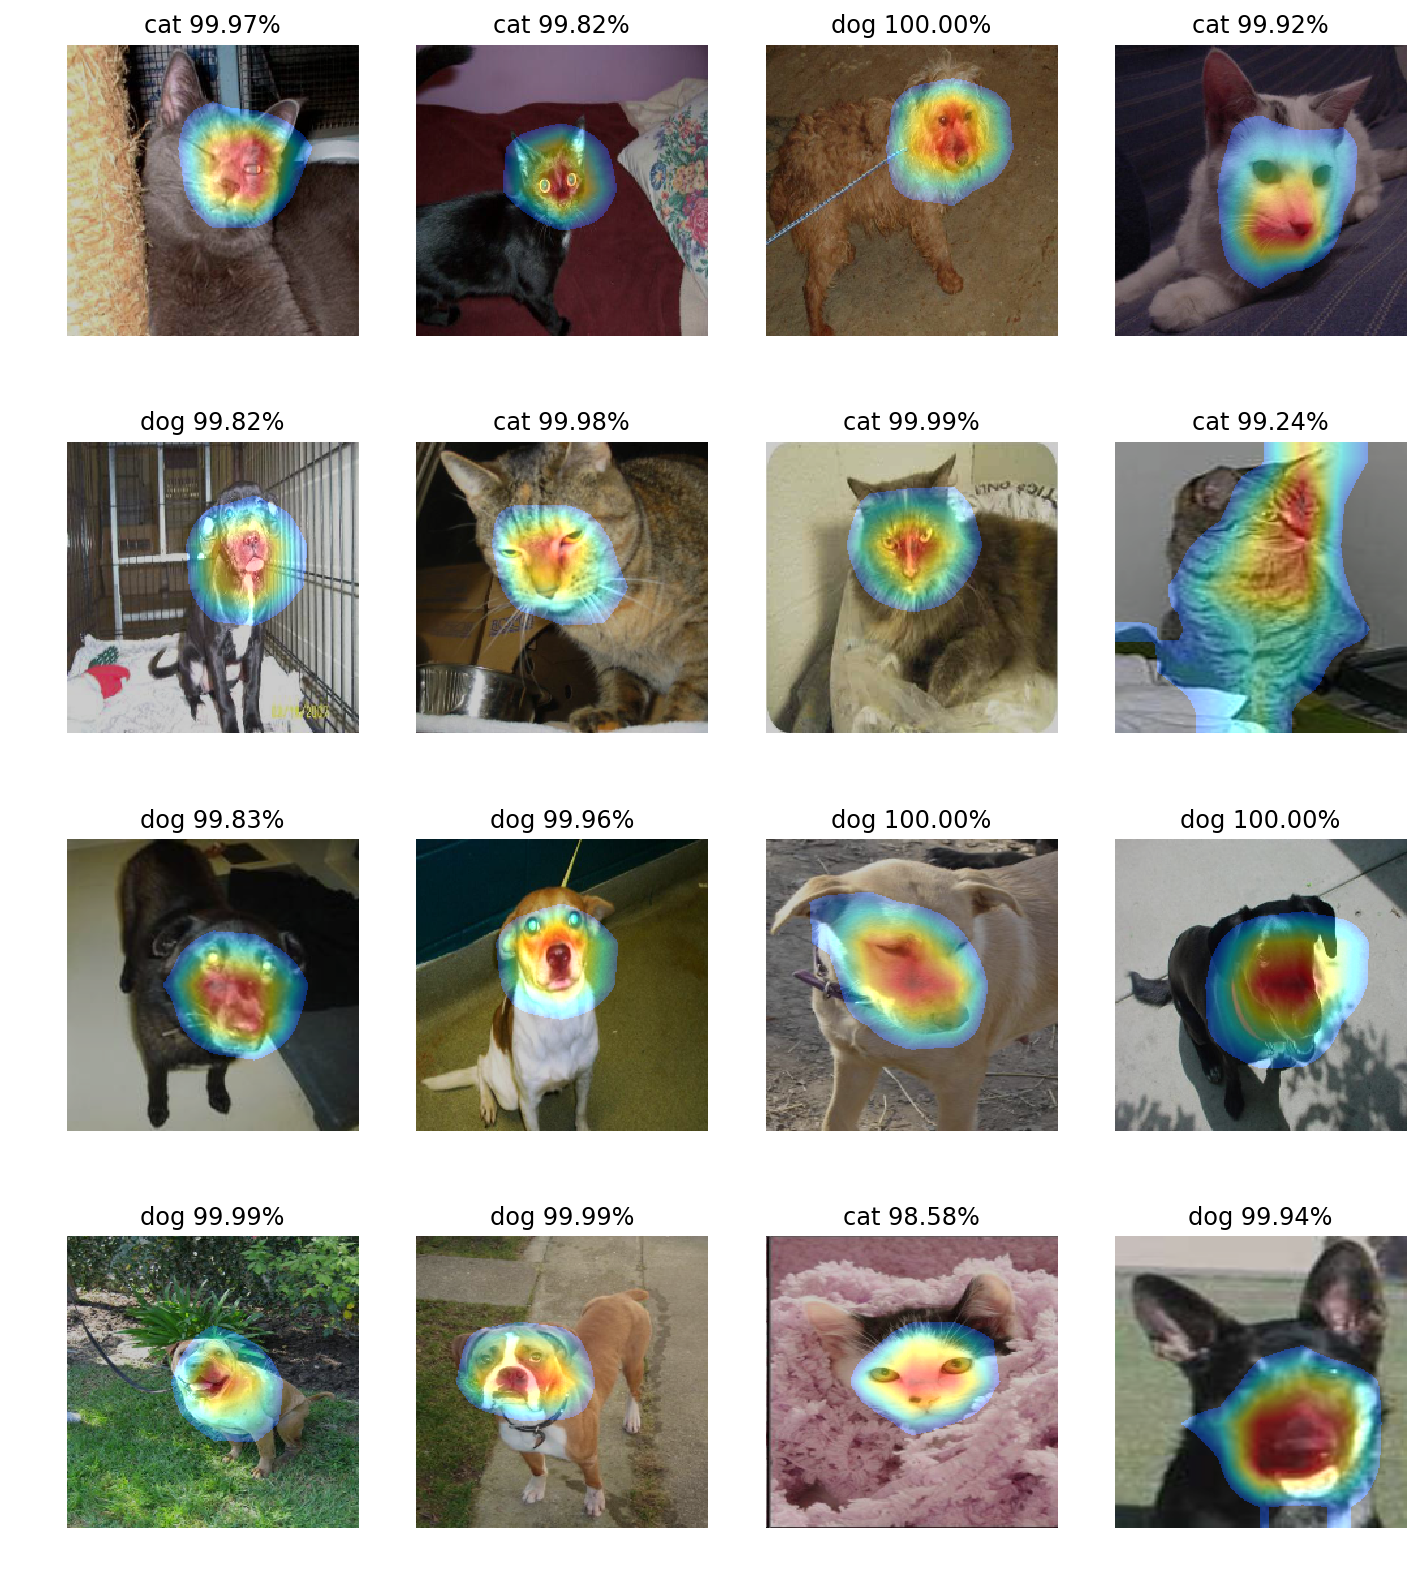

In [29]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = cv2.imread(data_path+'test/%d.jpg' % random.randint(1, 12500))
    img = cv2.resize(img, (224, 224))
    x = img.copy()
    x.astype(np.float32)
    out, prediction = model2.predict(np.expand_dims(x, axis=0))

    prediction = prediction[0]
    out = out[0]
    print(out.shape)
    
    plt.imshow(out[:,:,i])
    
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))

    cam = (prediction - 0.5) * np.matmul(out, weights)
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8

    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out[:,:,::-1])

# Fine-tune

http://keras-cn.readthedocs.io/en/latest/blog/image_classification_using_very_little_data/

In [13]:
for layer in model.layers[140:]:
    layer.trainable = True

In [15]:
model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_valid, y_valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 74s - loss: 0.0550 - acc: 0.9809 - val_loss: 0.0543 - val_acc: 0.9786
Epoch 2/5
20000/20000 [==============================] - 73s - loss: 0.0537 - acc: 0.9801 - val_loss: 0.0497 - val_acc: 0.9806
Epoch 3/5
20000/20000 [==============================] - 74s - loss: 0.0508 - acc: 0.9820 - val_loss: 0.0481 - val_acc: 0.9814
Epoch 4/5
20000/20000 [==============================] - 75s - loss: 0.0513 - acc: 0.9818 - val_loss: 0.0478 - val_acc: 0.9808
Epoch 5/5
20000/20000 [==============================] - 75s - loss: 0.0493 - acc: 0.9819 - val_loss: 0.0473 - val_acc: 0.9806


In [51]:
data_path='M:/dataset/dog_cat/'
data_path1=data_path+'test/1.jpg'
data_path2=data_path+'train/cat.1.jpg'
image=cv2.imread(data_path1)
print(image.shape)

(499, 381, 3)


In [59]:
m = 12500
data_path='M:/dataset/dog_cat/'
X_test = np.zeros((m, 224, 224, 3), dtype=np.uint8)

for i in tqdm(range(m)):
    X_test[i] = cv2.resize(cv2.imread(data_path+'test/%d.jpg' % (i+1)), (224, 224))

y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)
print(y_pred.shape)



100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:40<00:00, 306.27it/s]


12500/12500 [==============================] - 44s    
(12500, 1)


In [75]:
y_pred = model.predict(X_test, verbose=1)
y_pred1 = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 43s    


In [77]:
import pandas as pd
from keras.preprocessing.image import *

y_pred=np.array(y_pred1).transpose()
print(y_pred.shape)
print(y_pred[0])
head = ["id" , "label" ]
l=[]
for i in range(y_pred.shape[1]):
    l.append((i+1,y_pred[0][i]))
print(np.array(l).shape)
df = pd.DataFrame (l , columns = head)
df.to_csv('sample_submission_transfer_learning.csv', index=None)
df.head(10)


# result :sample_submission_transfer_learning.csv
#5 minutes ago
#0 seconds
#0 seconds
#0.06344
#greade:137 

(1, 12500)
[ 0.995  0.995  0.995 ...,  0.995  0.995  0.005]
(12500, 2)


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


In [49]:
np.random.seed(2017)

n = 25000
X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range( int(n/2) )):
    X[i] = cv2.resize(cv2.imread(data_path+'train/cat.%d.jpg' % i), (224, 224))
    X[i+int(n/2)] = cv2.resize(cv2.imread(data_path+'train/dog.%d.jpg' % i), (224, 224))

y[int(n/2):] = 1

  0%|                                                                                        | 0/12500 [00:00<?, ?it/s]


error: C:\projects\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:3483: error: (-215) ssize.width > 0 && ssize.height > 0 in function cv::resize
